In [52]:
import torch 
from torch import nn

import matplotlib.pyplot as plt

print(torch.__version__)

2.2.0


In [53]:
#this makes it so we get the same random values each time (and anyone running it does too)
MANUAL_RANDOM_SEED = 42

torch.manual_seed(MANUAL_RANDOM_SEED)

# Linear Regression Model 

Another example of a non-neural network model.

In [54]:
# "simple straight line"
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        #init model parameters to something random - only one node
        self.weight = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))
        
    #forward (computation) method
        #operation that the model does
    def forward(self, data:torch.Tensor) -> torch.Tensor:
        return self.weight * data + self.bias

In [55]:
#testing data

#for the sake of clarity - 
# we know what the ideal weight and bias is here
IDEAL_WEIGHT = 0.7
IDEAL_BIAS = 0.3

#all the data
#we want the model to : get x - return y
tensor32_x = torch.arange(0,1,0.02).unsqueeze(dim=1) #unsqueeze ; each value array of their own

tensor32_y = IDEAL_WEIGHT * tensor32_x + IDEAL_BIAS #lin reg formula

#splitting testing data 80 train - 20 test
point_to_split = int(0.8 * len(tensor32_x)) #80 % of data -> training set/split

train_set_X = tensor32_x[:point_to_split] #everything before the split
train_set_y = tensor32_y[:point_to_split]

test_set_X = tensor32_x[point_to_split:] #everything after the split (onwards)
test_set_y = tensor32_y[point_to_split:]


In [56]:
#plot function
def plot_predictions(
                    train_data,
                    train_labels,
                    test_data,
                    test_labels,
                    predictions=None):
    
    plt.figure(figsize=(10,7))

    if train_data is not None:
        #training data - blue
        plt.scatter(train_data, train_labels, c='b', s=4, label="training data")

    if test_data is not None:
        #test data - green ; what we are looking at
        plt.scatter(test_data, test_labels, c='g', s=4, label="testing data")


    #are there predictions 
    if predictions is not None:
        #predictions - red; what we got from the model ; ideal green = red
        plt.scatter(test_data, predictions, c='r', s=4, label="predictions")

    #legend
    plt.legend(prop={"size":14})

    plt.show() #opens a seperate window ..

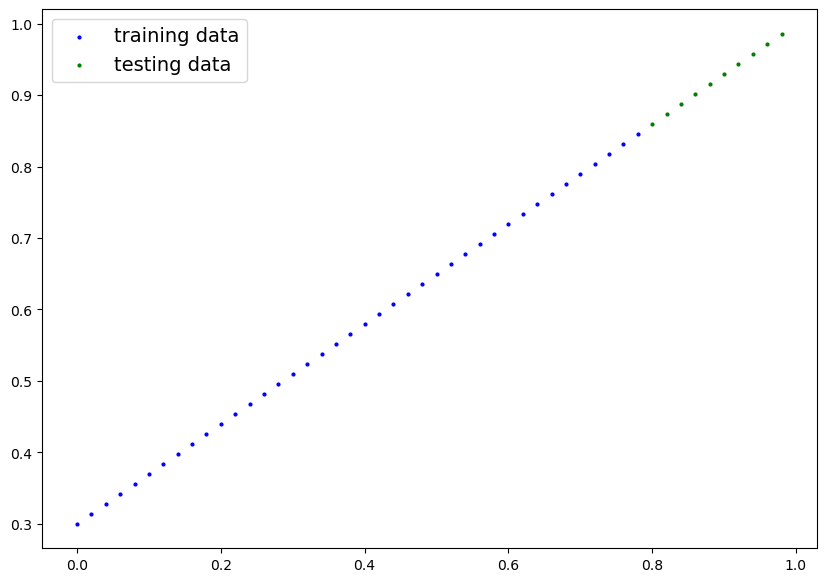

In [57]:
#show the split - of testing and training data
plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y)

In [58]:
#create instance of a model
linreg_model = LinearRegressionModel()

Let's see how our model preforms.

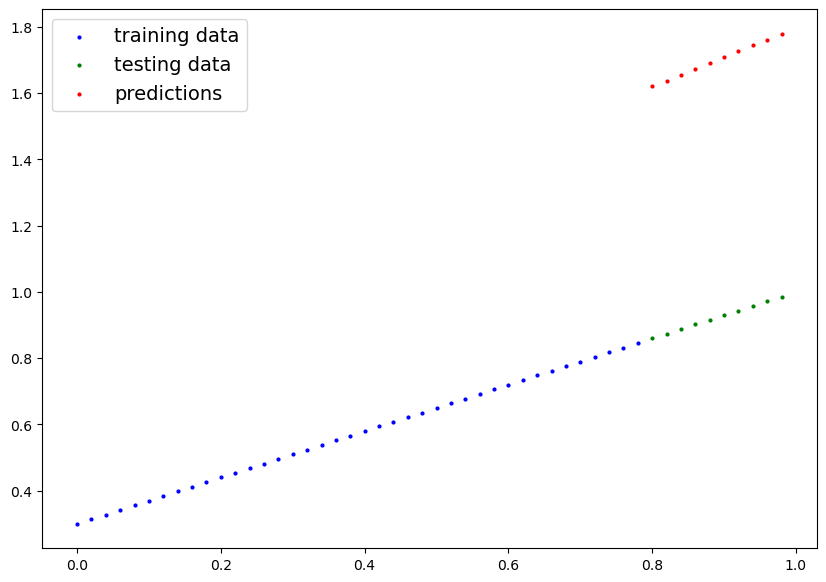

In [59]:
#testing the model before any training
with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
    predictions_y = linreg_model(test_set_X)

plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y, predictions=predictions_y)

.. It would appear an untrained model doesn't know what it is doing ! who would have though. But on a real note - this showcases what random initilazation does. 

The problem is that our model has no idea it is doing a bad job at predicting the linear values. This is where the loss function comes into play.

In linear regression models we generally use either MSE/L1.

In [60]:
loss_function = nn.L1Loss()

This is also when we pick our optimization algorithm. Let's pick SGD - so we can see what it changes in each iteration (ie. how the step works).

Because we are using SGD we will also need to provide a learning rate. (size of the step)

In [61]:
learning_rate = 0.01

In [62]:
optimization_algorithm = torch.optim.SGD(
    params=linreg_model.parameters(), #set by the model itself
    lr=learning_rate #learning rate ; hyperparameter we can set it ; adjustemnt per loop
    )

### Training and testing loop

In [63]:
#how many loops
epochs = 100

In [64]:
#training loop
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):

    #model - set training moed
    linreg_model.train() #all par that req grad - true

    #forward pass
    predictions_x = linreg_model(train_set_X)

    #calc loss
    loss = loss_function(predictions_x, train_set_y) #this should be 0

    #optimizer zero grad
    optimization_algorithm .zero_grad() #optimizes accumulates on each loop ; each it : fresh

    #preform backprop (from output - back ; red grad) ; backwards pass
    loss.backward()

    #preform gradient descent ; adjust - to get to the bottom (loss grad = 0)
    optimization_algorithm.step()


    #testing ------------------------------------------------------
    linreg_model.eval() #turn off grad tracking .. stuff not needed for evaluating
    
    with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
        test_predictions = linreg_model(test_set_X) #data it has never seen

        test_loss = loss_function(test_predictions, test_set_y)
    
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)

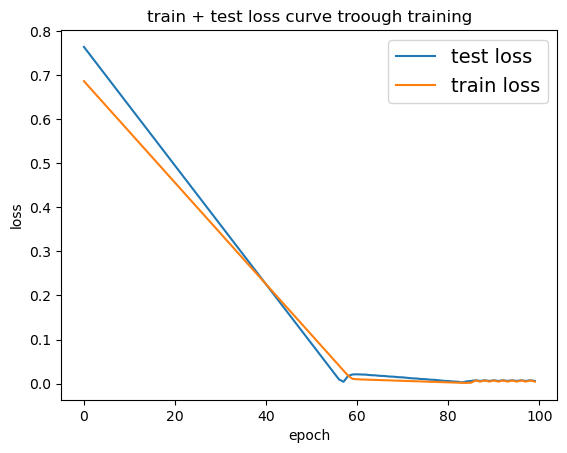

In [65]:
#visualize the curves

plt.plot(
            epoch_count, 
            torch.tensor(test_loss_values).numpy(),
            label="test loss")

plt.plot(       
            epoch_count, 
            torch.tensor(train_loss_values).numpy(),
            label="train loss")

plt.title("train + test loss curve troough training")

plt.ylabel("loss")
plt.xlabel('epoch')

#legend
plt.legend(prop={"size":14})

plt.show() 

Let's see how it preforms after training.

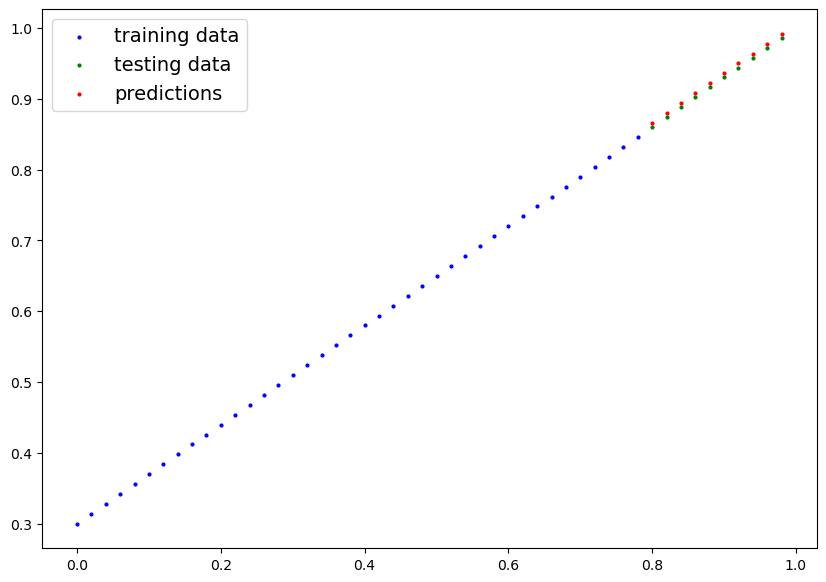

In [66]:
#testing the model before any training
with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
    predictions_y = linreg_model(test_set_X)

plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y, predictions=predictions_y)

So close !

Our model is now almost predicting the values correctly. This is where the more interactive part comes in. We have to change some **hyperparameters**.

> Let's also functionalize the training loop (generally we would have a seperate function for testing and training but for the sake of simplicity we won't)

In [67]:
def train_test_algorithm(linreg_model, loss_function, optimization_algorithm, train_set_X, train_set_y, test_set_X, test_set_y, epochs):
    epoch_count = []
    train_loss_values = []
    test_loss_values = []

    for epoch in range(epochs):
        # Model - set training mode
        linreg_model.train()  # all parameters that require gradients will be trained

        # Forward pass
        predictions_x = linreg_model(train_set_X)

        # Calculate loss
        loss = loss_function(predictions_x, train_set_y)

        # Optimizer zero grad
        optimization_algorithm.zero_grad()  # optimizer accumulates gradients on each loop; each iteration is fresh

        # Perform backpropagation (backwards pass)
        loss.backward()

        # Perform gradient descent; adjust to minimize loss
        optimization_algorithm.step()

        # Testing
        linreg_model.eval()  # turn off gradient tracking for evaluation
        with torch.no_grad():
            test_predictions = linreg_model(test_set_X)  # data it has never seen
            test_loss = loss_function(test_predictions, test_set_y)

        epoch_count.append(epoch)
        train_loss_values.append(loss.item())  # append loss.item() to save only the scalar value, not the tensor
        test_loss_values.append(test_loss.item())  # append test_loss.item() to save only the scalar value, not the tensor

    return epoch_count, train_loss_values, test_loss_values

Let's start by having the model train longer. 

In [68]:
epochs = 300

# lets train the model again
epoch_count, train_loss_values, test_loss_values = train_test_algorithm(
    linreg_model, loss_function, 
    optimization_algorithm, 
    train_set_X, 
    train_set_y, 
    test_set_X, 
    test_set_y, 
    epochs)

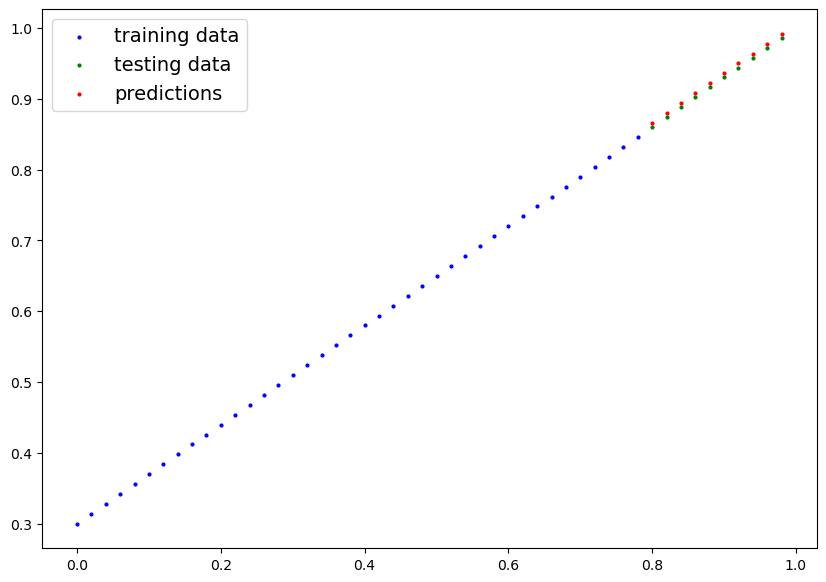

In [69]:
#testing the model before any training
with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
    predictions_y = linreg_model(test_set_X)

plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y, predictions=predictions_y)

Hm.. It would appear our model isn't getting any better at predicting - even with longer training.

Let's try changing the other hyperparameter - the learning rate too.

In [70]:
learning_rate = 0.003

In [71]:
optimization_algorithm = torch.optim.SGD(
    params=linreg_model.parameters(), #set by the model itself
    lr=learning_rate #learning rate ; hyperparameter we can set it ; adjustemnt per loop
    )

In [72]:
# lets train the model again
epoch_count, train_loss_values, test_loss_values = train_test_algorithm(
    linreg_model, loss_function, 
    optimization_algorithm, 
    train_set_X, 
    train_set_y, 
    test_set_X, 
    test_set_y, 
    epochs)

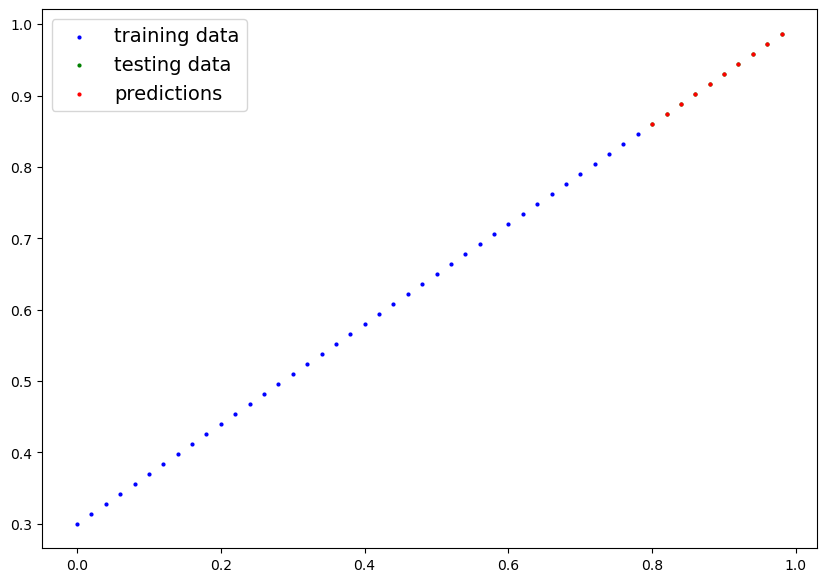

In [73]:
#testing the model before any training
with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
    predictions_y = linreg_model(test_set_X)

plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y, predictions=predictions_y)

.. Bingo ! Let's check our models parameters and see if they match the ones we set.

$weight = 0.7$

$bias = 0.3$

In [74]:
print("weight:", linreg_model.weight)

weight: Parameter containing:
tensor([0.6987], requires_grad=True)


In [75]:
print("bias:", linreg_model.bias)

bias: Parameter containing:
tensor([0.3019], requires_grad=True)
